# Figure 4: kilonovae

## Loading the BHNS population

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import sympy as sp
import os
from scipy.interpolate import RegularGridInterpolator
from functions import * 
import sys
sys.path.insert(0, '../COMPAS')
from spin_class import * 

num = 1000000 #number of binaries
eos = "SFHo" #assumed EoS
table = h5py.File('./population_data/bhns_%i_%s_z10_mass_spin_thv_GWFAST.hdf5' %(num,eos),'r') #EM and GW population
mns_max = 2.058838 #NS maximum mass for the assumed SFHo EoS

DCOtype='BHNS'
poptype='A'
path = './population_data/COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5' #from Broekgaarden+21 

distribution = 'NOT fixed' #or 'fixed' for the same mass distribution at each redshift (approximated redshift evolution)
spin_prescription = 'Zero' #/Qin21/Uniform/Bavera21

### --- Loading Population --- ###

print("Loading intrinsic population")
mbh = table['mbh'][()] #mass of the primary component
mns = table['mns'][()] #mass of the secondary component
lamb_ns = table['lamb_ns'][()] #NS deformability
spin_bh = table['spin_bh'][()] #BH spin
i_tilt = table['i_tilt'][()] #angle between spin and angular momentum 
z = table['z'][()] #redshift
dL = table['dL'][()] #luminosity distance
thv = table['thv'][()] #viewing angle
ra = table['ra'][()]
dec = table['dec'][()]
m_dyn = table['m_dyn'][()] #dynamical ejecta mass
v_dyn = table['v_dyn'][()] #dynamical ejecta velocity
m_disk = table['m_disk'][()] #disk mass
m_out = table['m_out'][()] #ejected mass
final_x = table['final_x'][()] #final spin
E_bkt = table['E_bkt'][()] #brekout energy
E_k_jet = table['E_k_jet'][()] #jet kinetic energy
Ec = table['Ec'][()] #jet core energy

print("Loading GW population")
snr_LVKO4_duty = table['snr_LVKO4_duty'][()] #SNRs LVK O4
snr_LVKIO5_duty = table['snr_LVKIO5_duty'][()] #SNRs LVKI O5

print("Loading EM population (kilonova)")
kn_waves = table['kn_waves'][()] #KN bands = g, z, J
t_kn = table['t_kn'][()] #KN time
lc_kn = table['lc_kn'][()] #KN abs mag

table.close()

Loading intrinsic population
Loading GW population
Loading EM population (kilonova)


## Weighing the BHNS population

In [3]:
### --- Weights --- ###

if poptype == 'A':
    w_type='w_000'
    r0 = 149 
    w_type_high = 'w_000'
    r0_high = 302
    w_type_low = 'w_000'
    r0_low = 62
    
if poptype == 'B':
    w_type='w_000'
    r0 = 20
    w_type_high = 'w_000'
    r0_high = 100
    w_type_low = 'w_000'
    r0_low = 10

spin = calculate_spin_olderCOMPASdata(data_path=path)
if spin_prescription == 'Bavera21':
    spinM1, spinM2  = spin.Bavera21()
if spin_prescription == 'Qin21':
    spinM1, spinM2  = spin.Qin21()
if spin_prescription == 'Uniform':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.5,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.5,spinM2.shape)
elif spin_prescription == 'Zero':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.,spinM2.shape)

bhx=[2.5,27]
nsx=[1.1,3]
spinx=[0.,1.]
binsx=50
binsy=50
binsz=50

if distribution == 'fixed':
    C_mc, w = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0,5.e-2,path,w_type,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    
if distribution == 'NOT fixed':
    C_mc, w = f_weights(mbh,mns,thv,spin_bh,z,r0,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)

print("")
print("EoS:",eos)
print("Population model:",poptype)
print("The mass and spin distributions are", distribution)
if distribution == 'fixed':
    print("The fiducial SFRD is", w_type, "with r0 =", r0)
    print("The higher limit SFRD is", w_type_high, "with r0 =", r0_high)
    print("The lower limit SFRD is", w_type_low, "with r0 =", r0_low)
print("The spin prescription is:", spin_prescription)
print("")

Computing weights

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero



In [5]:
#GW
print("Computing GW limiting thresholds")
lim_snr = 12
gw_det = snr_LVKO4_duty >= lim_snr

Computing GW limiting thresholds


In [6]:
# transform absolute magnitudes to apparent
lc_kn_APP = np.zeros([num,len(kn_waves),len(t_kn)])

for i in range(len(kn_waves)):
    for j in range(len(t_kn)):
        lc_kn_APP[:,i,j] = abs_to_app(lc_kn[:,i,j],dL*1.e6)

mpk_g = np.min(lc_kn_APP[:,0], axis=1)
mpk_z = np.min(lc_kn_APP[:,1], axis=1)
mpk_J = np.min(lc_kn_APP[:,2], axis=1)

mpk_g_3 = np.min(lc_kn_APP[:,0,29:], axis=1)
mpk_z_3 = np.min(lc_kn_APP[:,1,29:], axis=1)
mpk_J_3 = np.min(lc_kn_APP[:,2,29:], axis=1)

mpk_g_5 = np.min(lc_kn_APP[:,0,34:], axis=1)
mpk_z_5 = np.min(lc_kn_APP[:,1,34:], axis=1)
mpk_J_5 = np.min(lc_kn_APP[:,2,34:], axis=1)

# construct confidence regions
perc = [0.01,0.05,0.25,0.5,0.75,0.95,0.99]

conf_curves_g=np.zeros([len(perc),len(t_kn)])
conf_curves_z=np.zeros([len(perc),len(t_kn)])
conf_curves_J=np.zeros([len(perc),len(t_kn)])

for i in range(len(t_kn)):
    conf_curves_g[:,i]=corner.quantile(lc_kn_APP[:,0,i],perc,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)))
    conf_curves_z[:,i]=corner.quantile(lc_kn_APP[:,1,i],perc,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)))
    conf_curves_J[:,i]=corner.quantile(lc_kn_APP[:,2,i],perc,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)))

/Users/Alberto/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Alberto/miniconda3/envs/astro/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


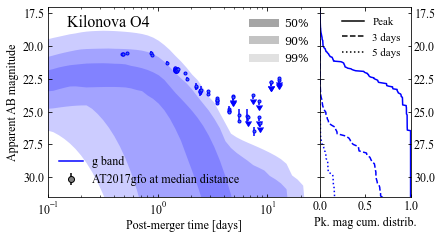

In [7]:
recomp_gaussian = False
recomp_uniform = False
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.figsize']=6.3,3.3
plt.rcParams['figure.autolayout']=True
plt.rcParams['mathtext.fontset']='dejavuserif'
plt.rcParams["axes.axisbelow"] = False

# plot confidence curves
kn_bands = ['g']
kn_colors = ['blue']

left=0.1
bottom=0.14
width=0.6
height=0.8
plt.axes([left,bottom,width,height])

for i,conf in enumerate([conf_curves_g]):
    plt.fill_between(t_kn,conf[0],conf[-1],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)
    plt.fill_between(t_kn,conf[1],conf[-2],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)
    plt.fill_between(t_kn,conf[2],conf[-3],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)

if True: # add AT2017gfo for comparison
    ## find median distance
    W = w*gw_det*(m_out>0)
    s = np.argsort(dL)
    dL_cdf = np.cumsum(W[s])
    dL_cdf/=dL_cdf[-1]
    dL0 = np.sort(dL)
    dL_median = np.interp(0.5,dL_cdf,dL0)
    dL_mean = np.average(dL,weights=w*gw_det)
    #print(dL_median,dL_mean)
 
    mjd_gw = 57982.5285
    at2017gfo = pandas.read_csv('./AT2017gfo/At2017gfo_photometry.csv')
    dist_mod = 5*np.log10(dL_median/40.)
    zband = at2017gfo['band'].astype(str)=='z'
    gband = at2017gfo['band'].astype(str)=='g'
    Jband = at2017gfo['band'].astype(str)=='J'
    uplims = at2017gfo['upperlimit'].astype(str)=='T'
    at2017gfo['e_magnitude'][uplims]=-0.3
    extinction = {'g':0.4,'z':0.16,'J':0.087} # r: 0.28
    
    plt.errorbar(at2017gfo['time'][gband]-mjd_gw,at2017gfo['magnitude'][gband]+dist_mod-extinction['g'],yerr=at2017gfo['e_magnitude'][gband],markersize=3,markerfacecolor="royalblue",color='blue',ls='None',marker='o',uplims=uplims[gband])
    #plt.errorbar(at2017gfo['time'][zband]-mjd_gw,at2017gfo['magnitude'][zband]+dist_mod-extinction['z'],yerr=at2017gfo['e_magnitude'][zband],markersize=3,markeredgecolor='#B11313',color='red',ls='None',marker='o',uplims=uplims[zband])    
    #plt.errorbar(at2017gfo['time'][Jband]-mjd_gw,at2017gfo['magnitude'][Jband]+dist_mod-extinction['J'],yerr=at2017gfo['e_magnitude'][Jband],markersize=3,markeredgecolor='#B11313',color='red',ls='None',marker='o',uplims=uplims[Jband])

plt.errorbar(100,100,yerr=1000,color='black',markerfacecolor="grey",ls='None',label='AT2017gfo at median distance',marker='o')
plt.plot([0.],[0.],color='blue',label='g band')

leg1=plt.legend([Line2D([0],[0],color='dimgrey',lw=8,alpha=0.6),Line2D([0],[0],color="dimgrey",lw=8,alpha=0.4),Line2D([0],[0],color='dimgrey',lw=8,alpha=0.2)],[r'$50\%$',r'$90\%$',r'$99\%$'],loc =1,prop={'size': 11},frameon=False)
plt.gca().add_artist(leg1)

plt.text(0.15,18.5,"Kilonova O4",size=16)

ylim = [31.5,17]

plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlim([1e-1,30.])
plt.ylim(ylim)
plt.xlabel(r'Post-merger time [days]',size=12,labelpad=2)
plt.ylabel(r'Apparent AB magnitude',size=12)
plt.tick_params(which='both',direction='in',top=True,right=True,labelsize=12)
plt.legend(loc='lower left',frameon=False,prop={'size': 12})

# construct cumulative peak mag distribution
#np.histogram
s_mpk_g,bins_g,patches = plt.hist(mpk_g,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)
#s_mpk_J,bins_J,patches = plt.hist(mpk_J,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)
s_mpk_z,bins_z,patches = plt.hist(mpk_z,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)

bincentre_g = np.zeros(len(bins_g)-1)
bincentre_z = np.zeros(len(bins_z)-1)
#bincentre_J = np.zeros(len(bins_g)-1)
for j in range(len(bins_g)-1):
    bincentre_g[j] = bins_g[j] + (bins_g[j+1] - bins_g[j]) / 2.
    bincentre_z[j] = bins_z[j] + (bins_z[j+1] - bins_z[j]) / 2.
    #bincentre_J[j] = bins_J[j] + (bins_J[j+1] - bins_J[j]) / 2.
    
s_mpk_g_3,bins_g_3,patches = plt.hist(mpk_g_3,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)
s_mpk_z_3,bins_z_3,patches = plt.hist(mpk_z_3,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)
#s_mpk_J_3,bins_J_3,patches = plt.hist(mpk_J_3,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)

bincentre_g_3 = np.zeros(len(bins_g_3)-1)
bincentre_z_3 = np.zeros(len(bins_z_3)-1)
#bincentre_J_3 = np.zeros(len(bins_g_3)-1)
for j in range(len(bins_g_3)-1):
    bincentre_g_3[j] = bins_g_3[j] + (bins_g_3[j+1] - bins_g_3[j]) / 2.
    bincentre_z_3[j] = bins_z_3[j] + (bins_z_3[j+1] - bins_z_3[j]) / 2.
    #bincentre_J_3[j] = bins_J_3[j] + (bins_J_3[j+1] - bins_J_3[j]) / 2.
    
s_mpk_g_5,bins_g_5,patches = plt.hist(mpk_g_5,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)
s_mpk_z_5,bins_z_5,patches = plt.hist(mpk_z_5,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)
#s_mpk_J_5,bins_J_5,patches = plt.hist(mpk_J_5,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)

bincentre_g_5 = np.zeros(len(bins_g_5)-1)
bincentre_z_5 = np.zeros(len(bins_z_5)-1)
#bincentre_J_5 = np.zeros(len(bins_g_5)-1)
for j in range(len(bins_g_5)-1):
    bincentre_g_5[j] = bins_g_5[j] + (bins_g_5[j+1] - bins_g_5[j]) / 2.
    bincentre_z_5[j] = bins_z_5[j] + (bins_z_5[j+1] - bins_z_5[j]) / 2.
    #bincentre_J_5[j] = bins_J_5[j] + (bins_J_5[j+1] - bins_J_5[j]) / 2.

# plot cumulative distributions
plt.axes([left+width,bottom,1-left-width-0.1,height])
plt.plot(s_mpk_g,bincentre_g,color=kn_colors[0])
#plt.plot(s_mpk_z,bincentre_z,color=kn_colors[1])
#plt.plot(s_mpk_J,bincentre_J,color=kn_colors[1])

plt.plot(s_mpk_g_3,bincentre_g_3,color=kn_colors[0],ls="--")
#plt.plot(s_mpk_z_3,bincentre_z_3,color=kn_colors[1],ls="--")
#plt.plot(s_mpk_J_3,bincentre_J_3,color=kn_colors[1],ls="--")

plt.plot(s_mpk_g_5,bincentre_g_5,color=kn_colors[0],ls=":")
#plt.plot(s_mpk_z_5,bincentre_z_5,color=kn_colors[1],ls=":")
#plt.plot(s_mpk_J_5,bincentre_J_5,color=kn_colors[1],ls=":")

plt.axvline(10,c='black',ls='-',label='Peak')
plt.axvline(10,c='black',ls='--',label='3 days')
plt.axvline(10,c='black',ls=':',label='5 days')

plt.legend(frameon=False,prop={'size': 11})
plt.ylim(ylim)
plt.xlim([0.,1.])
plt.tick_params(which='both',direction='in',labelleft=False,labelright=True,right=True,top=True,labelsize=12)
plt.xlabel('Pk. mag cum. distrib.',size=12)

plt.show()

/Users/Alberto/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Alberto/miniconda3/envs/astro/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


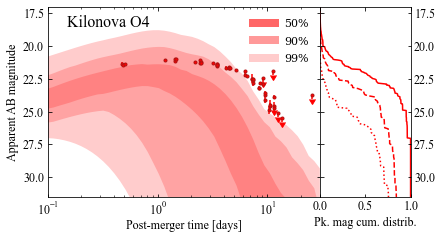

In [9]:
recomp_gaussian = False
recomp_uniform = False
plt.rcParams['font.family']="Times New Roman"
#plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize']=6.3,3.3
plt.rcParams['figure.autolayout']=True
plt.rcParams['mathtext.fontset']='dejavuserif'
plt.rcParams["axes.axisbelow"] = False

# plot confidence curves
kn_bands = ['J']
kn_colors = ['red']

left=0.1
bottom=0.14
width=0.6
height=0.8
plt.axes([left,bottom,width,height])

for i,conf in enumerate([conf_curves_J]):
    plt.fill_between(t_kn,conf[0],conf[-1],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)
    plt.fill_between(t_kn,conf[1],conf[-2],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)
    plt.fill_between(t_kn,conf[2],conf[-3],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)

if True: # add AT2017gfo for comparison
    ## find median distance
    W = w*gw_det*(m_out>0)
    s = np.argsort(dL)
    dL_cdf = np.cumsum(W[s])
    dL_cdf/=dL_cdf[-1]
    dL0 = np.sort(dL)
    dL_median = np.interp(0.5,dL_cdf,dL0)
    dL_mean = np.average(dL,weights=w*gw_det)
    #print(dL_median,dL_mean)
 
    mjd_gw = 57982.5285
    at2017gfo = pandas.read_csv('./AT2017gfo/At2017gfo_photometry.csv')
    dist_mod = 5*np.log10(dL_median/40.)
    zband = at2017gfo['band'].astype(str)=='z'
    gband = at2017gfo['band'].astype(str)=='g'
    Jband = at2017gfo['band'].astype(str)=='J'
    uplims = at2017gfo['upperlimit'].astype(str)=='T'
    at2017gfo['e_magnitude'][uplims]=-0.3
    extinction = {'g':0.4,'z':0.16,'J':0.087} # r: 0.28
    
    #plt.errorbar(at2017gfo['time'][gband]-mjd_gw,at2017gfo['magnitude'][gband]+dist_mod-extinction['g'],yerr=at2017gfo['e_magnitude'][gband],markersize=3,markerfacecolor="royalblue",color='blue',ls='None',marker='o',uplims=uplims[gband])
    #plt.errorbar(at2017gfo['time'][zband]-mjd_gw,at2017gfo['magnitude'][zband]+dist_mod-extinction['z'],yerr=at2017gfo['e_magnitude'][zband],markersize=3,markeredgecolor='#B11313',color='red',ls='None',marker='o',uplims=uplims[zband])    
    plt.errorbar(at2017gfo['time'][Jband]-mjd_gw,at2017gfo['magnitude'][Jband]+dist_mod-extinction['J'],yerr=at2017gfo['e_magnitude'][Jband],markersize=3,markeredgecolor='#B11313',color='red',ls='None',marker='o',uplims=uplims[Jband])

#plt.errorbar(100,100,yerr=1000,color='black',markerfacecolor="grey",ls='None',label='AT2017gfo at median distance',marker='o')
plt.plot([0.],[0.],color='red',label='J band')
#plt.plot([0.],[0.],color='red',label='z')

#plt.fill_between([1.e1,2.e1],[20.,20.],[17.5,17.5],color="grey",alpha=0.2,edgecolor=None)
#plt.fill_between([1.e1,2.e1],[19.5,19.5],[18.,18.],color="grey",alpha=0.2,edgecolor=None)
#plt.fill_between([1.e1,2.e1],[19.,19.],[18.5,18.5],color="grey",alpha=0.2,edgecolor=None)

#plt.text(5.5,18.,"99%",size=11)
#plt.text(5.5,18.5,"90%",size=11)
#plt.text(5.5,19.,"50%",size=11)

leg1=plt.legend([Line2D([0],[0],color='r',lw=8,alpha=0.6),Line2D([0],[0],color="r",lw=8,alpha=0.4),Line2D([0],[0],color='r',lw=8,alpha=0.2)],[r'$50\%$',r'$90\%$',r'$99\%$'],loc =1,prop={'size': 11},frameon=False)
#plt.gca().add_artist(leg1)

plt.text(0.15,18.5,"Kilonova O4",size=16)

ylim = [31.5,17]

plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlim([1e-1,30.])
plt.ylim(ylim)
plt.xlabel(r'Post-merger time [days]',size=12,labelpad=2)
plt.ylabel(r'Apparent AB magnitude',size=12)
plt.tick_params(which='both',direction='in',top=True,right=True,labelsize=12)
#plt.legend(loc='lower left',frameon=False,prop={'size': 12})

# construct cumulative peak mag distribution
#np.histogram
s_mpk_g,bins_g,patches = plt.hist(mpk_g,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)
s_mpk_J,bins_J,patches = plt.hist(mpk_J,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)
s_mpk_z,bins_z,patches = plt.hist(mpk_z,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)

bincentre_g = np.zeros(len(bins_g)-1)
bincentre_z = np.zeros(len(bins_z)-1)
bincentre_J = np.zeros(len(bins_g)-1)
for j in range(len(bins_g)-1):
    bincentre_g[j] = bins_g[j] + (bins_g[j+1] - bins_g[j]) / 2.
    bincentre_z[j] = bins_z[j] + (bins_z[j+1] - bins_z[j]) / 2.
    bincentre_J[j] = bins_J[j] + (bins_J[j+1] - bins_J[j]) / 2.
    
s_mpk_g_3,bins_g_3,patches = plt.hist(mpk_g_3,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)
s_mpk_z_3,bins_z_3,patches = plt.hist(mpk_z_3,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)
s_mpk_J_3,bins_J_3,patches = plt.hist(mpk_J_3,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)

bincentre_g_3 = np.zeros(len(bins_g_3)-1)
bincentre_z_3 = np.zeros(len(bins_z_3)-1)
bincentre_J_3 = np.zeros(len(bins_g_3)-1)
for j in range(len(bins_g_3)-1):
    bincentre_g_3[j] = bins_g_3[j] + (bins_g_3[j+1] - bins_g_3[j]) / 2.
    bincentre_z_3[j] = bins_z_3[j] + (bins_z_3[j+1] - bins_z_3[j]) / 2.
    bincentre_J_3[j] = bins_J_3[j] + (bins_J_3[j+1] - bins_J_3[j]) / 2.
    
s_mpk_g_5,bins_g_5,patches = plt.hist(mpk_g_5,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)
s_mpk_z_5,bins_z_5,patches = plt.hist(mpk_z_5,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)
s_mpk_J_5,bins_J_5,patches = plt.hist(mpk_J_5,weights=w*gw_det*((m_dyn>1.e-6)|(m_disk>1.e-5)),cumulative=1, density = 1, bins=1000)

bincentre_g_5 = np.zeros(len(bins_g_5)-1)
bincentre_z_5 = np.zeros(len(bins_z_5)-1)
bincentre_J_5 = np.zeros(len(bins_g_5)-1)
for j in range(len(bins_g_5)-1):
    bincentre_g_5[j] = bins_g_5[j] + (bins_g_5[j+1] - bins_g_5[j]) / 2.
    bincentre_z_5[j] = bins_z_5[j] + (bins_z_5[j+1] - bins_z_5[j]) / 2.
    bincentre_J_5[j] = bins_J_5[j] + (bins_J_5[j+1] - bins_J_5[j]) / 2.

# plot cumulative distributions
plt.axes([left+width,bottom,1-left-width-0.1,height])
#plt.plot(s_mpk_g,bincentre_g,color=kn_colors[0])
#plt.plot(s_mpk_z,bincentre_z,color=kn_colors[1])
plt.plot(s_mpk_J,bincentre_J,color=kn_colors[0])

#plt.plot(s_mpk_g_3,bincentre_g_3,color=kn_colors[0],ls="--")
#plt.plot(s_mpk_z_3,bincentre_z_3,color=kn_colors[1],ls="--")
plt.plot(s_mpk_J_3,bincentre_J_3,color=kn_colors[0],ls="--")

#plt.plot(s_mpk_g_5,bincentre_g_5,color=kn_colors[0],ls=":")
#plt.plot(s_mpk_z_5,bincentre_z_5,color=kn_colors[1],ls=":")
plt.plot(s_mpk_J_5,bincentre_J_5,color=kn_colors[0],ls=":")

plt.axvline(10,c='black',ls='-',label='Peak')
plt.axvline(10,c='black',ls='--',label='3 days')
plt.axvline(10,c='black',ls=':',label='5 days')

#plt.legend(frameon=False,prop={'size': 11})
plt.ylim(ylim)
plt.xlim([0.,1.])
plt.tick_params(which='both',direction='in',labelleft=False,labelright=True,right=True,top=True,labelsize=12)
plt.xlabel('Pk. mag cum. distrib.',size=12)

plt.show()